# Bi-Directional Attention Flow Model

#### Set Checkpoint and Data Folder

In [1]:
!pip install -U PyYAML
!pip install -U h5py
!pip install pytorch-lightning
!pip install matplotlib

Requirement already up-to-date: PyYAML in /home/julian/Development/PythonEnv/pytorch/lib/python3.8/site-packages (5.3.1)
Requirement already up-to-date: h5py in /home/julian/Development/PythonEnv/pytorch/lib/python3.8/site-packages (2.10.0)


In [2]:
import sys, os
import torch
pwd = os.getcwd()

class Arguments():
    data = os.path.join(pwd, 'DATA', 'train_v2.1.json')
    exp_folder = os.path.join(pwd, 'Experimente/LightningTest')
    word_rep = os.path.join(pwd, 'DATA', 'glove.840B.300d.txt')
    #word_rep = None
    cuda = torch.cuda.is_available()
    use_covariance = False
    force_restart = False
    train_data = os.path.join(pwd, 'DATA', 'train_v2.1.json')
    val_data = os.path.join(pwd, 'DATA', 'dev_v2.1.json')
    test_data = os.path.join(pwd, 'DATA', 'eval_v2.1_public.json')

args = Arguments()

if not os.path.exists(args.exp_folder):
    os.makedirs(args.exp_folder)


#### Global Configurations (instead of config.yaml)

In [3]:
import yaml

config_yaml = """
    bidaf:
        dropout: 0.2
        num_highways: 2
        num_lstm: 2
        hidden_size: 100
        embedding_dim: 300
        embedding_reduce: 100
        characters:
            dim: 16
            num_filters: 100
            filter_sizes:
                - 5
    training:
        lr: 0.001
        betas:
            - 0.9
            - 0.999
        eps: 0.00000001
        weigth_decay: 0
        epochs: 1
        batch_size: 60
        limit: 400
"""
config = yaml.load(config_yaml, Loader=yaml.FullLoader)


#### Importing the MSMARCO Bidaf Model

In [4]:
sys.path.append(os.path.join(pwd,'MsmarcoQuestionAnswering','Baseline'))
sys.path.append(os.path.join(pwd,'MsmarcoQuestionAnswering','Baseline','scripts'))

import MsmarcoQuestionAnswering.Baseline.scripts.checkpointing as checkpointing
import MsmarcoQuestionAnswering.Baseline.scripts.train as train_manager
import MsmarcoQuestionAnswering.Baseline.scripts.predict as predict_manager
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import h5py

In [11]:
import MsmarcoQuestionAnswering.Baseline.mrcqa as mrcqa
import MsmarcoQuestionAnswering.Baseline.scripts.dataset as dataset
import json as json
import numpy as np



def load_data(path,limit):
    with open(path) as f_o:
        data, _ = dataset.load_data(json.load(f_o), span_only=True, answered_only=True, loading_limit=limit)
    return data

def load_model_from_checkpoint(config, checkpoint):
    model, id_to_token, id_to_char = mrcqa.BidafModel.from_checkpoint(config['bidaf'], checkpoint)
    if torch.cuda.is_available() and args.cuda:
        model.cuda()
    model.train()
    return (model, id_to_token, id_to_char)

def init_model(id_to_token, id_to_char):
    return mrcqa.BidafModel.from_config(config['bidaf'], id_to_token, id_to_char)

def reload_model(checkpoint):
    model, id_to_token, id_to_char = mrcqa.BidafModel.from_checkpoint(config['bidaf'], checkpoint)
    if torch.cuda.is_available() and args.cuda:
        model.cuda()
    model.train()
    return model, id_to_token, id_to_char

def inverse_dict(base_dict):
    return {tok: id_ for id_, tok in base_dict.items()}

def get_loader(data, config):
    data = dataset.EpochGen(
        data,
        batch_size=config.get('training', {}).get('batch_size', 32),
        shuffle=True)
    return data

def get_optimizer(model, config, state):
    """
    Get the optimizer
    """
    parameters = filter(lambda p: p.requires_grad,
                        model.parameters())
    optimizer = torch.optim.Adam(
        parameters,
        lr=config['training'].get('lr', 0.01),
        betas=config['training'].get('betas', (0.9, 0.999)),
        eps=config['training'].get('eps', 1e-8),
        weight_decay=config['training'].get('weight_decay', 0))

    if state is not None:
        optimizer.load_state_dict(state)

    return optimizer

def load_pretrained_embeddings(path, model, id_to_token):
    with open(path) as f_o:
            pre_trained = dataset.SymbolEmbSourceText(f_o, set(tok for id_, tok in id_to_token.items() if id_ != 0))
    mean, cov = pre_trained.get_norm_stats(args.use_covariance)
    rng = np.random.RandomState(2)
    oovs = dataset.SymbolEmbSourceNorm(mean, cov, rng, args.use_covariance)
    model.embedder.embeddings[0].embeddings.weight.data = torch.from_numpy(dataset.symbol_injection(id_to_token, 0, model.embedder.embeddings[0].embeddings.weight.data.numpy(), pre_trained, oovs))

In [12]:
def new_init(train_path, val_path, test_path, config, args, loading_limit):
    token_to_id = {'': 0}
    char_to_id = {'': 0}
    print('Load Train Data [1/6]')
    train_data = load_data(train_path,loading_limit)
    print('Load Validation Data [1/6]')
    val_data = load_data(val_path,loading_limit)
    #print('Load Test Data [1/6]')
    #test_data = load_data(test_path,loading_limit)
    
    print('Tokenize Data [2/6]')
    train_data = dataset.tokenize_data(train_data, token_to_id, char_to_id)
    val_data = dataset.tokenize_data(val_data, token_to_id, char_to_id)
    #test_data = dataset.tokenize_data(test_data, token_to_id, char_to_id)
    
    train_loader = get_loader(train_data, config)
    val_loader = get_loader(val_data, config)
    #test_loader = get_loader(test_data, config)

    print('Create Inverse Dictionaries [3/6]')
    id_to_token = inverse_dict(token_to_id)
    id_to_char = inverse_dict(char_to_id)

    print('Initiate Model [4/6]')
    model = init_model(id_to_token, id_to_char)

    if args.word_rep:
        print('Load pre-trained embeddings [5/6]')
        load_pretrained_embeddings(args.word_rep, model, id_to_token)
    else:
        print('No pre-trained embeddings given [5/6]')
        pass  # No pretraining, just keep the random values.

    if torch.cuda.is_available() and args.cuda:
        model.cuda()
    model.train()

    optimizer = get_optimizer(model, config, state=None)
    print('Done init_state [6/6]')
    return model, id_to_token, id_to_char, optimizer, train_loader, val_loader#, test_loader   


def new_reload(train_path, val_path, test_path, checkpoint, training_state, config, args,loading_limit):
    print('Load Model from Checkpoint [1/5]')
    model, id_to_token, id_to_char = reload_model(checkpoint)

    optimizer = get_optimizer(model, config, training_state)

    print('Create Inverse Dictionaries [2/5]')
    token_to_id = inverse_dict(id_to_token)
    char_to_id = inverse_dict(id_to_char)

    len_tok_voc = len(token_to_id)
    len_char_voc = len(char_to_id)

    print('Load Train Data [3/5]')
    train_data = load_data(train_path,loading_limit)
    print('Load Validation Data [3/5]')
    val_data = load_data(val_path,loading_limit)
    
    
    limit_passage = config.get('training', {}).get('limit')

    print('Tokenize Data [4/5]')
    train_data = dataset.tokenize_data(train_data, token_to_id, char_to_id)
    val_data = dataset.tokenize_data(val_data, token_to_id, char_to_id)
    
    train_loader = get_loader(train_data, config)
    val_loader = get_loader(val_data, config)

    assert len(token_to_id) == len_tok_voc
    assert len(char_to_id) == len_char_voc

    print('Done reload_state [5/5]')
    return model, id_to_token, id_to_char, optimizer, train_loader, val_loader


#### Pytorch Lightning Wrapper

In [13]:
checkpoint_w, training_state_w, epoch_w = train_manager.try_to_resume(
            args.force_restart, args.exp_folder)

if checkpoint_w:
    print('Resuming training...')
    model_w, id_to_token_w, id_to_char_w, optimizer_w, train_loader, val_loader = new_reload(args.train_data, args.val_data, args.test_data, checkpoint_w, training_state_w, config, args,10000)
else:
    print('Preparing to train...')
    model_w, id_to_token_w, id_to_char_w, optimizer_w, train_loader, val_loader = new_init(args.train_data, args.val_data, args.test_data,config, args,10000)
    checkpoint_w = h5py.File(os.path.join(args.exp_folder, 'checkpoint'))
    checkpointing.save_vocab(checkpoint_w, 'vocab', id_to_token_w)
    checkpointing.save_vocab(checkpoint_w, 'c_vocab', id_to_char_w)

if torch.cuda.is_available() and args.cuda:
    train_loader.tensor_type = torch.cuda.LongTensor
    val_loader.tensor_type = torch.cuda.LongTensor
    #test_loader.tensor_type = torch.cuda.LongTensor

Resuming training...
Load Model from Checkpoint [1/5]


/home/julian/Development/PythonEnv/pytorch/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Create Inverse Dictionaries [2/5]
Load Train Data [3/5]
Start Organizing Data...
Organizing progress: 0.0 x 10⁴
Load Validation Data [3/5]
Start Organizing Data...
Organizing progress: 0.0 x 10⁴
Tokenize Data [4/5]
0.0 x 10⁴/0.3696 x 10⁴
0.0 x 10⁴/0.1989 x 10⁴
Done reload_state [5/5]


In [14]:
epoch_saves = dict();
epoch_saves['train_loss'] = []
epoch_saves['val_loss'] = []


class BidafLightningWrapper(LightningModule):
    def __init__(self):
        super().__init__()
        
    def setup(self,stage):
        pass;
            
    def prepare_data(self):
        pass;

    def configure_optimizers(self):
        return optimizer_w;

    def forward(self, passage, p_lengths, question, q_lengths):
        return model_w(passage, p_lengths, question, q_lengths)

    def train_dataloader(self):
        return train_loader;
    
    def val_dataloader(self):
        return val_loader;

    def training_step(self, batch, batch_idx):
        qids, passages, queries, answers, _ = batch
        start_log_probs, end_log_probs = self(passages[:2], passages[2], queries[:2], queries[2])
        loss = model_w.get_loss(start_log_probs, end_log_probs, answers[:, 0], answers[:, 1])
        return {'loss': loss, 'log': {'train_loss': loss}}

    def training_epoch_end(self, results):
        checkpointing.checkpoint(model_w, epoch_w, optimizer_w, checkpoint_w, args.exp_folder)
        loss = torch.stack([step['loss'] for step in results]).mean()
        model_w.cuda()
        epoch_saves['train_loss'].append([step['loss'] for step in results])
        return {'log': {'train_loss': loss}}
    
    def validation_step(self, batch, batch_idx):
        qids, passages, queries, answers, _ = batch
        start_log_probs, end_log_probs = self(passages[:2], passages[2], queries[:2], queries[2])
        loss = model_w.get_loss(start_log_probs, end_log_probs, answers[:, 0], answers[:, 1])
        return {'val_loss': loss, 'log': {'val_loss': loss}}
    
    def validation_epoch_end(self, results):
        val_loss_mean = torch.stack([step['val_loss'] for step in results]).mean()
        epoch_saves['val_loss'].append([step['val_loss'] for step in results])
        return {'val_loss': val_loss_mean}
'''
    def test_step(self, batch, batch_idx):
        return {'test_loss': loss}

    def test_epoch_end(self, results):
        loss = torch.stack([step['test_loss'] for step in results]).mean()
        return {'log': {'test_loss': loss}}
'''



"\n    def test_step(self, batch, batch_idx):\n        return {'test_loss': loss}\n\n    def test_epoch_end(self, results):\n        loss = torch.stack([step['test_loss'] for step in results]).mean()\n        return {'log': {'test_loss': loss}}\n"

In [15]:
modelLightning = BidafLightningWrapper()
trainer = Trainer(max_epochs=10, gpus=1)
trainer.fit(modelLightning)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------


Epoch 1:  65%|██████▍   | 62/96 [00:20<00:11,  2.99it/s, loss=2.537, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 2:  65%|██████▍   | 62/96 [00:20<00:11,  2.98it/s, loss=2.220, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 3:  65%|██████▍   | 62/96 [00:22<00:12,  2.72it/s, loss=2.043, v_num=1]
Validating: 0it [00:00, ?it/s]
Epoch 4:   3%|▎         | 3/96 [00:01<00:40,  2.32it/s, loss=1.994, v_num=1] 


/home/julian/Development/PythonEnv/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [16]:
from pathlib import Path
outputfile = os.path.join(args.exp_folder,'statistics.json')
Path(outputfile).touch()

#### Save Loss to statistics.json

In [17]:
def writeStatisticToDict(key, output_dict):
    output_dict[key] = dict()
    stat_saves = epoch_saves[key]

    for idx in range(0,len(stat_saves)):
        output_dict[key][idx] = dict()
        for jdx in range(0,len(stat_saves[idx])):
            output_dict[key][idx][jdx] = stat_saves[idx][jdx].item() 

In [18]:
output_dict = dict()

writeStatisticToDict('train_loss',output_dict)
writeStatisticToDict('val_loss',output_dict)

with open(outputfile, 'w') as write_f:
    write_f.write(json.dumps(output_dict))

#### Load Loss from statistics.json

In [19]:
with open(outputfile, 'r') as read_f:
    statistics = json.load(read_f)

In [22]:
from matplotlib import pyplot as plt
def visualizeLoss(key, stats):
    batch_stats = stats[key]
    epoch_stats = []
    for key in batch_stats:
        epoch_stats = epoch_stats + list(batch_stats[key].values())
    plt.plot(epoch_stats)

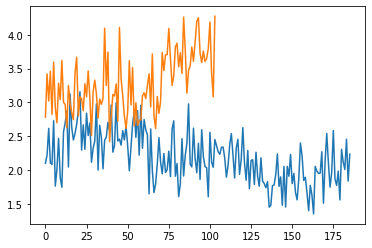

In [23]:
visualizeLoss('train_loss', statistics)
visualizeLoss('val_loss',statistics)